Bank Note Authentication UCI Project

Aim of the project:
- Put in practice what I have learned about creating a very simple ML model for binary classification
- More importantly how to deploy the model via REST API using Flask
- Contenarizing the project with Docker for the portability, consistency, and scalability that is offers while deploying applications in different environments

Problem statement:\
- Data were extracted from images that were taken from genuine and forged banknote-like specimens. 
- For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels.
-  Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. 
- Wavelet Transform tool were used to extract features from images.

The data set includes information about:
- variance: variance of Wavelet Transformed image (continuous)
- skewness: skewness of Wavelet Transformed image (continuous)
- curtosis: curtosis of Wavelet Transformed image (continuous)
- entropy: entropy of image (continuous)
- class (integer)

Data Collection

Link to the dataset: https://www.kaggle.com/datasets/ritesaluja/bank-note-authentication-uci-data

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("../datasets/BankNote_Authentication.csv")

In [98]:
df.tail()

,variance,skewness,curtosis,entropy,class
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1
1371,-2.54190,-0.65804,2.6842,1.19520,1


Dataset information

In [8]:
df.keys()

Index(['variance', 'skewness', 'curtosis', 'entropy', 'class'], dtype='object')

Features summary:

- variance: is a measure of the dispersion of the values of a sample or random variable 
- skewness: is the asymmetry of the distribution of a real random variable
- curtosis: is a direct measure of the acuity and an indirect measure of the kurtosis of the distribution of a real random variable
- entropy: the degree of disorganization of a system



Data checks

In [9]:
# Count missing values (null)
df.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [10]:
# Count missing values (empty strings)
df.eq(' ').sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [11]:
# Look for missing values
df.isna().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

In [15]:
df.duplicated().sum()

0

In [16]:
df.loc[df.duplicated()]

,variance,skewness,curtosis,entropy,class


In [14]:
#Drop the duplicates after the verifications
df = df.drop_duplicates()

In [17]:
# infromation about the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1348 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1348 non-null   float64
 1   skewness  1348 non-null   float64
 2   curtosis  1348 non-null   float64
 3   entropy   1348 non-null   float64
 4   class     1348 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 63.2 KB


In [23]:
# data description without the labels
df.describe(exclude="int64")

,variance,skewness,curtosis,entropy
count,1348.000000,1348.000000,1348.000000,1348.000000
mean,0.445785,1.909039,1.413578,-1.168712
std,2.862906,5.868600,4.328365,2.085877
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.786650,-1.627000,-1.545600,-2.393100
50%,0.518735,2.334150,0.605495,-0.578890
75%,2.853250,6.796025,3.199800,0.403863
max,6.824800,12.951600,17.927400,2.449500


Data exploration

In [32]:
# define numerical features
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
# remove labels
numeric_features.remove("class")

<Axes: >

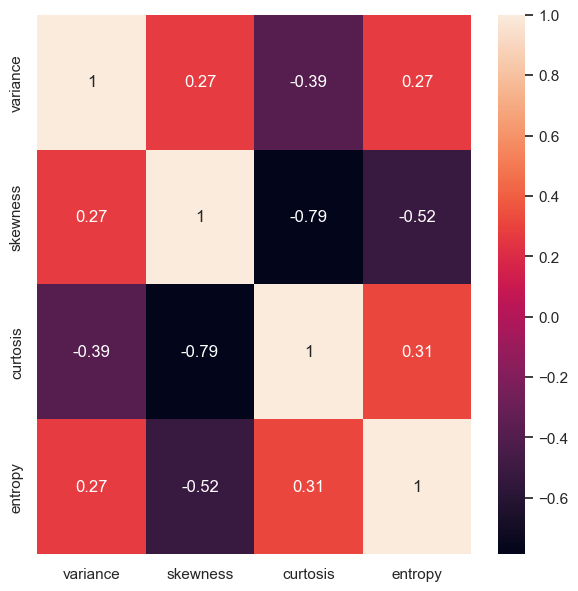

In [33]:
# Graphing the correlation between numerical features
plt.figure(figsize = (7,7))
sns.set(style = 'whitegrid')
sns.heatmap(df[numeric_features].corr(), annot = True)

C:\Users\Ronan\AppData\Local\Temp\ipykernel_16952\173077738.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='class', data=df, palette="flare", stat="percent")


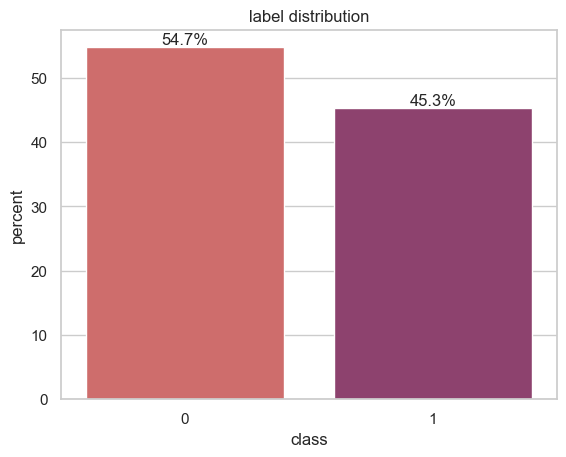

In [36]:
# Check the label distribution
ax = sns.countplot(x='class', data=df, palette="flare", stat="percent")
ax.set_title('label distribution')
for bar in range(len(ax.containers)):
    ax.bar_label(ax.containers[bar], fmt='%.1f%%')

We can say that the distribution is well balanced but we could try to apply some feature transformation to even the distribution

In [37]:
# Drop the label from the dataset since the EDA phase is done
X = df.drop('class', axis=1)
y = df['class']

In [46]:
# Create the data splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Print shape of training, test, and cross-validation data
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Test Data Shape: {X_test.shape}")
print(f"Test Target Shape: {y_test.shape}")

# Note: The stratify parameter makes a split so that the proportion of values in the sample
#produced will be the same as the proportion of values provided by parameter stratify

Training Data Shape: (1078, 4)
Training Target Shape: (1078,)
Test Data Shape: (270, 4)
Test Target Shape: (270,)


In [49]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

# All the features need to be scaled
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [50]:
# Save the scaler object
import pickle
pickle.dump(scaler, open('scaler.sav', 'wb'))

In [58]:
colums = [""]

#X_train = pickle.load(pickle.dumps(# Transform the training, cross validation, and test set
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_features)

In [59]:
X_train_scaled

,variance,skewness,curtosis,entropy
0,-0.235417,-1.420575,1.598328,-0.174851
1,0.447685,0.856480,-0.599711,-0.200702
2,-1.437353,-0.242604,0.226428,0.331813
3,-0.046463,-0.460941,-0.129639,0.904327
4,1.246920,-0.739144,0.211572,1.040988
...,...,...,...,...
1073,1.203254,-0.005244,-0.314227,1.135773
1074,0.092363,1.225540,-0.589145,-0.164377
1075,-1.512308,-2.483729,2.611210,-0.795362
1076,-2.387202,0.813509,-0.188887,-2.788054


<Axes: xlabel='entropy', ylabel='Count'>

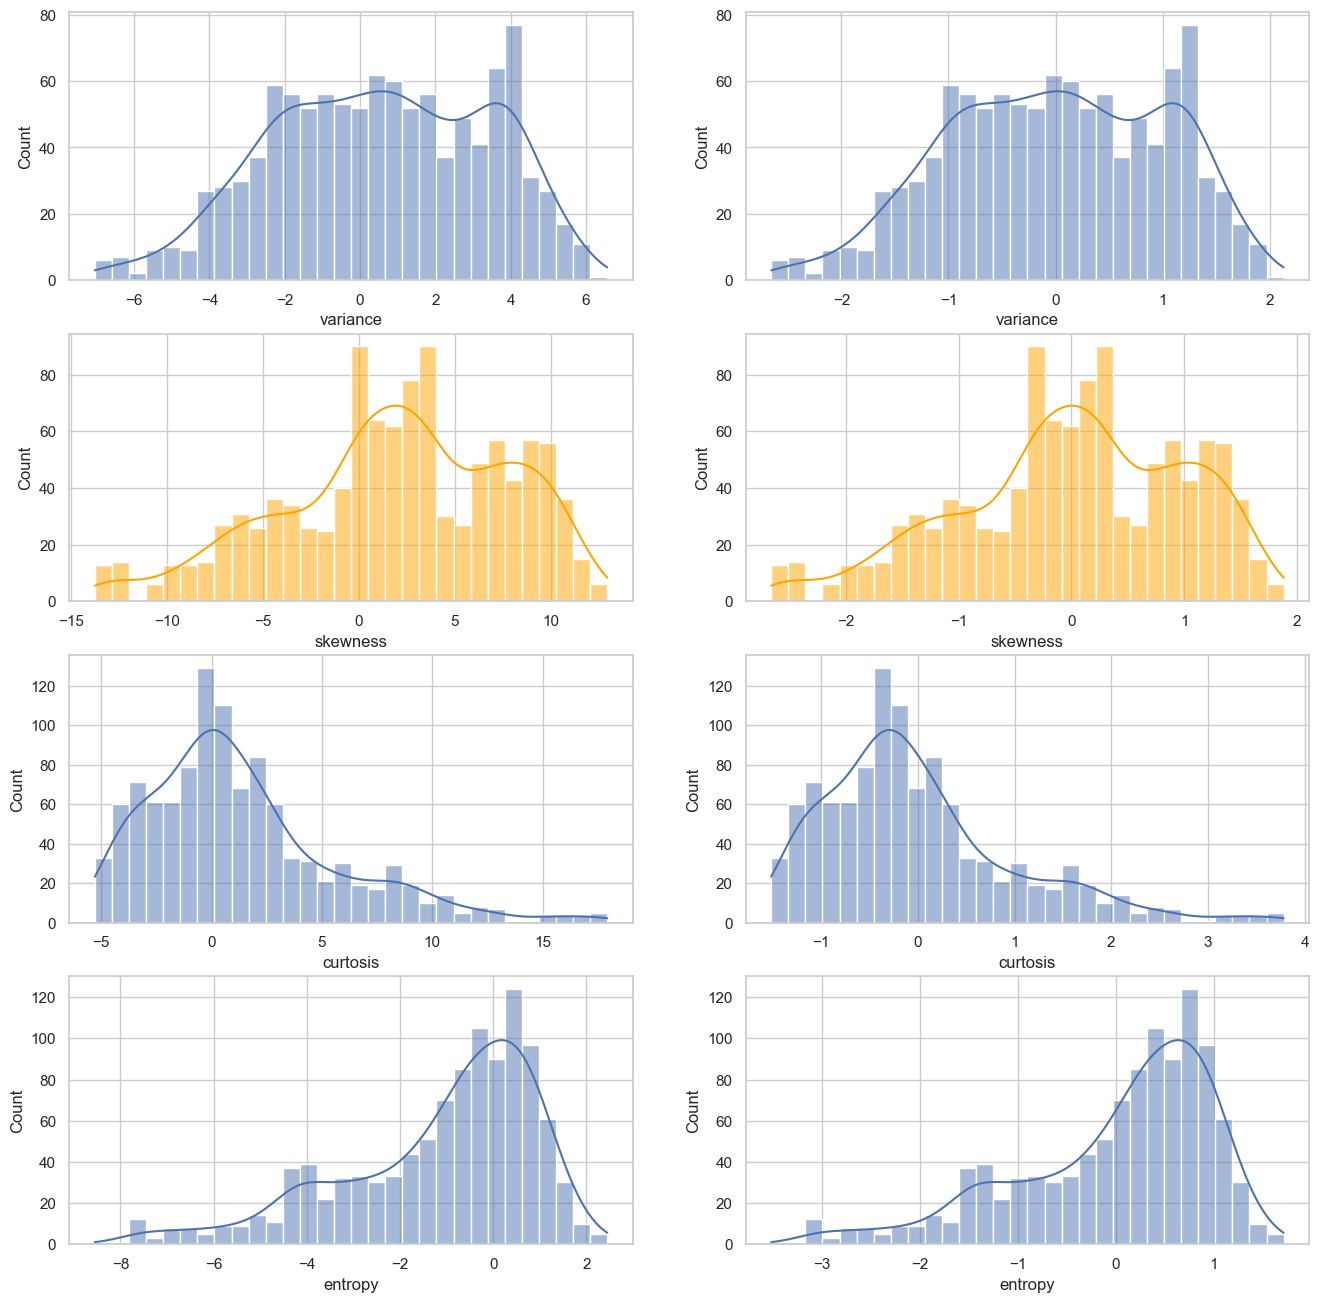

In [64]:

# Plot the training set as reference to verify correct scaling
plt.figure(figsize = (16,16))
sns.set(style = 'whitegrid')

plt.subplot(4,2,1)
sns.histplot(data = X_train['variance'], bins = 30, kde = True)

plt.subplot(4,2,2)
sns.histplot(data = X_train_scaled['variance'], bins = 30, kde = True)

plt.subplot(4,2,3)
sns.histplot(data = X_train['skewness'], bins = 30, kde = True, color = 'orange')

plt.subplot(4,2,4)
sns.histplot(data = X_train_scaled['skewness'], bins = 30, kde = True, color = 'orange')

plt.subplot(4,2,5)
sns.histplot(data = X_train['curtosis'], bins = 30, kde = True)

plt.subplot(4,2,6)
sns.histplot(data = X_train_scaled['curtosis'], bins = 30, kde = True)

plt.subplot(4,2,7)
sns.histplot(data = X_train['entropy'], bins = 30, kde = True)

plt.subplot(4,2,8)
sns.histplot(data = X_train_scaled['entropy'], bins = 30, kde = True)

Quantile Transformer\
We can transform the column tenure and MonthlyCharges using a Quantile Transformer function, which is a common non-parametric statistical method used to transform the dataset into a Gaussian Distribution.\
Therefore, for a given feature, this transformation tends to spread out the most frequent values.\
It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.\
This is included in scikit-learn preprocessing libary, named QuantileTransformer

In [66]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution = 'normal')
qt.fit(X_train_scaled)

X_train_trans = qt.transform(X_train_scaled)
X_test_trans = qt.transform(X_test_scaled)

X_train_trans = pd.DataFrame(X_train_trans, columns=numeric_features)
X_test_trans = pd.DataFrame(X_test_trans, columns=numeric_features)

In [94]:
X_test_trans.tail()

,variance,skewness,curtosis,entropy
265,-0.021462,-0.222049,0.800638,-0.252040
266,0.229613,0.425420,0.495965,0.504133
267,-0.331451,-0.150160,-0.635135,-0.282266
268,0.491952,-1.099462,0.833856,-0.336453
269,0.445710,-0.033762,0.463034,0.306115


<Axes: xlabel='entropy', ylabel='Count'>

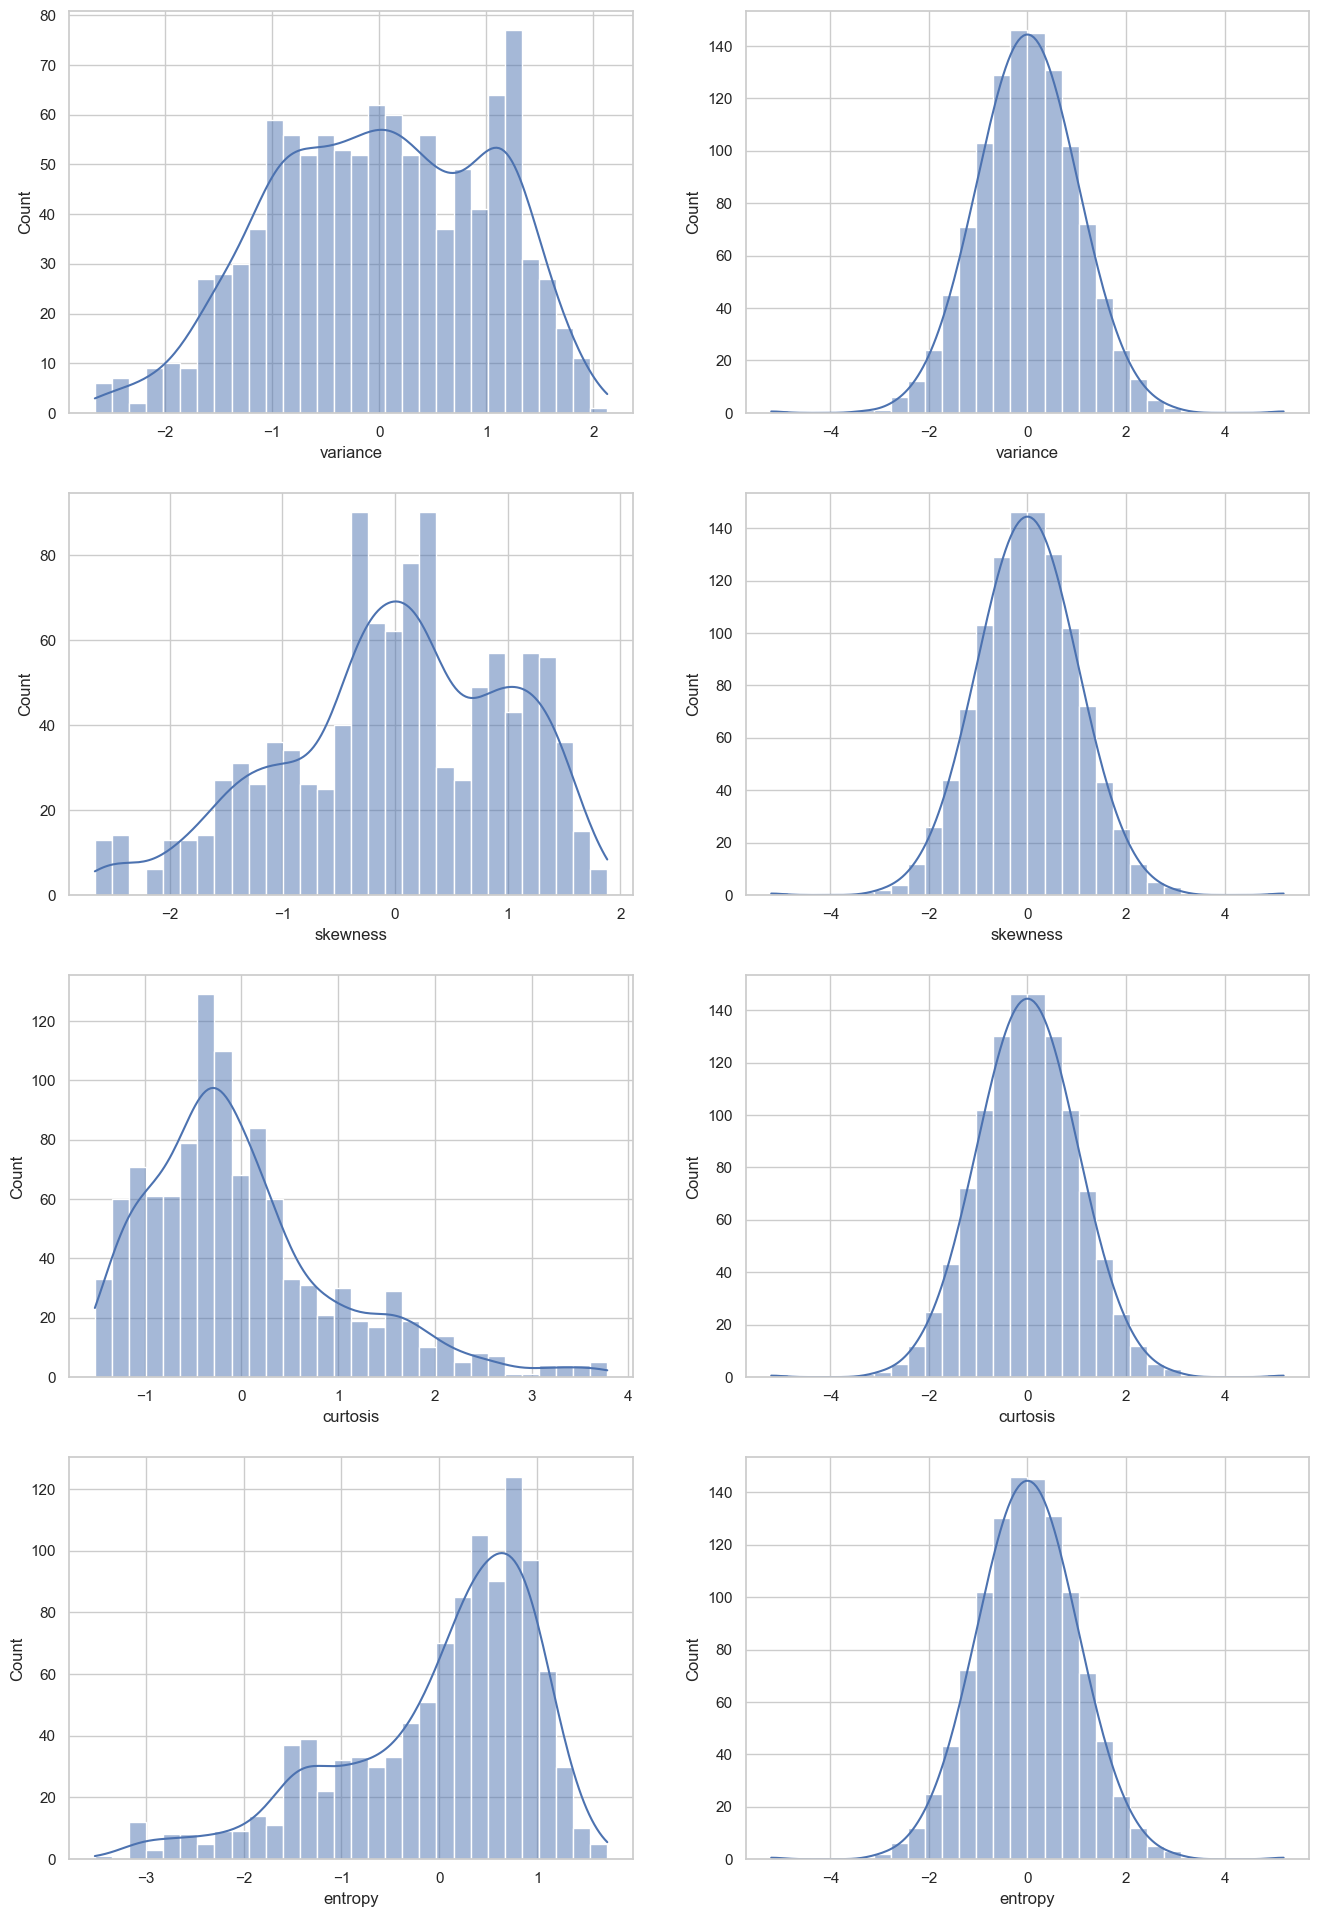

In [76]:
# Graph the instances on a histogram
plt.figure(figsize = (16,24))
sns.set(style = 'whitegrid')

plt.subplot(4,2,1)
sns.histplot(data = X_train_scaled['variance'], bins = 30, kde = True)

plt.subplot(4,2,2)
sns.histplot(data = X_train_trans['variance'], bins = 30, kde = True)

plt.subplot(4,2,3)
sns.histplot(data = X_train_scaled['skewness'], bins = 30, kde = True)

plt.subplot(4,2,4)
sns.histplot(data = X_train_trans['skewness'], bins = 30, kde = True)

plt.subplot(4,2,5)
sns.histplot(data = X_train_scaled['curtosis'], bins = 30, kde = True)

plt.subplot(4,2,6)
sns.histplot(data = X_train_trans['curtosis'], bins = 30, kde = True)

plt.subplot(4,2,7)
sns.histplot(data = X_train_scaled['entropy'], bins = 30, kde = True)

plt.subplot(4,2,8)
sns.histplot(data = X_train_trans['entropy'], bins = 30, kde = True)

In [77]:
# Save the quantile transformation
pickle.dump(qt, open('quantile.sav', 'wb'))

In [78]:

from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, mean_squared_error
def roc_print(y_true, y_pred):
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

RandomForestClassifier without hyperparameter tuning

In [80]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=46)
rf.fit(X_train_trans, y_train)

RandomForestClassifier(random_state=46)

In [81]:
from sklearn.metrics import accuracy_score
rf_pred = rf.predict(X_test)
print(accuracy_score(rf_pred, y_test))

0.825925925925926


In [82]:
from sklearn.metrics import classification_report
print("Classification Report")
print(classification_report(y_test, rf_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       148
           1       0.86      0.73      0.79       122

    accuracy                           0.83       270
   macro avg       0.83      0.82      0.82       270
weighted avg       0.83      0.83      0.82       270



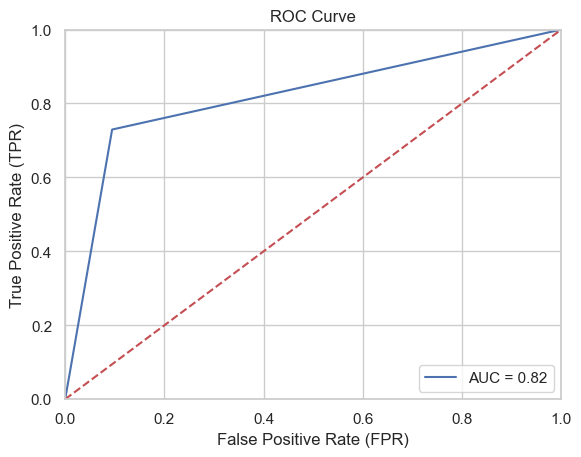

In [84]:
# Print ROC Curve
roc_print(y_test, rf_pred)

Linear Regression without hyperparameter tuning

In [86]:
from sklearn.linear_model import LogisticRegression
# Train the logistic regression model
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train_trans, y_train)

LogisticRegression()

In [87]:
lr_pred = lr.predict(X_test_trans)
print("Classification Report")
print(classification_report(y_test, lr_pred))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.99      1.00      1.00       122

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



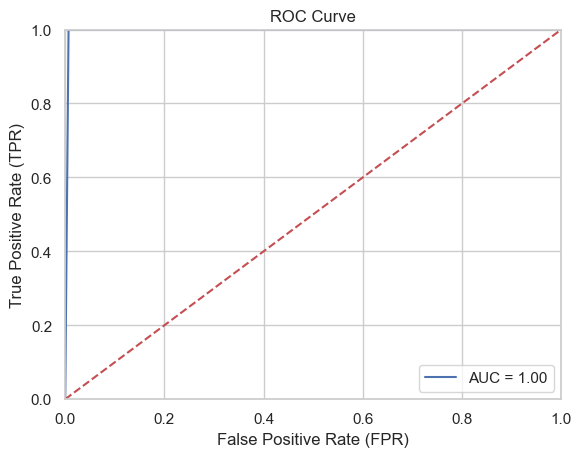

In [88]:
# Print ROC Curve
roc_print(y_test, lr_pred)

We found the best model without hyperparameter tuning with a perfect AUC score !!!

In [89]:
# We save the linear regression model
pickle.dump(lr, open('linear_regression.pkl', 'wb'))

Test the pickled model

In [108]:
result = lr.predict(scaler.transform(qt.transform([[0.6, 1.5, -1.3, -0.8]])))[0]
print("Predicted class:", result)

Predicted class: 1
